### Class

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

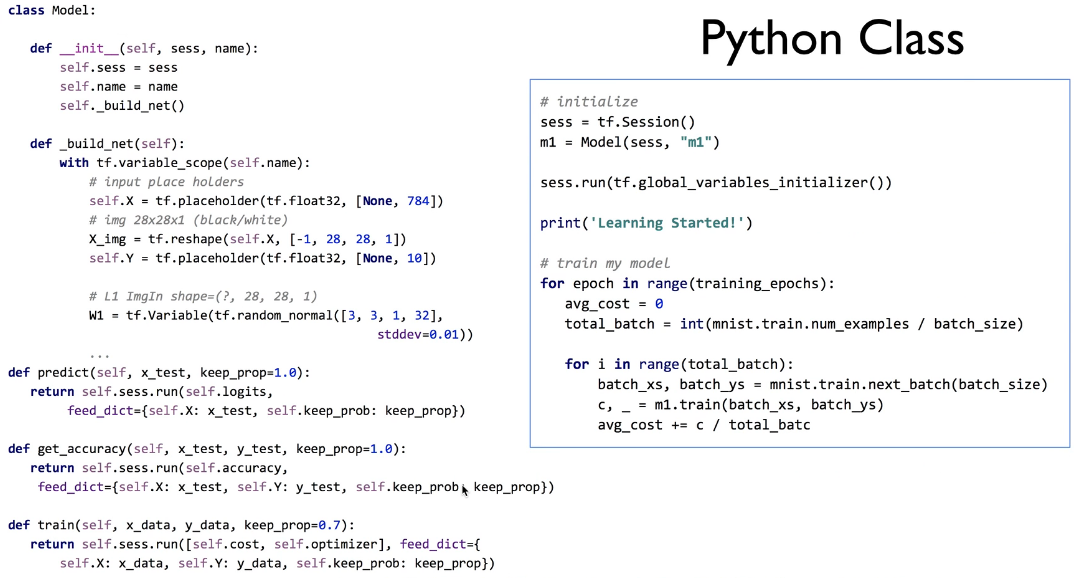

In [4]:
class Model :
    
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()
        
    def _build_net(self) :
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.keep_prob = tf.placeholder(tf.float32)
            
            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])
            
            # img 28x28x1 (black/white)
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])
            
            # L1 ImgIn shape=(?, 28, 28, 1)
            W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
            #    Conv     -> (?, 28, 28, 32)
            #    Pool     -> (?, 14, 14, 32)
            L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
            L1 = tf.nn.relu(L1)
            L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            L1 = tf.nn.dropout(L1, keep_prob=self.keep_prob)
            
            # L2 ImgIn shape=(?, 14, 14, 32)
            W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
            #    Conv      ->(?, 14, 14, 64)
            #    Pool      ->(?, 7, 7, 64)
            L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
            L2 = tf.nn.relu(L2)
            L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            L2 = tf.nn.dropout(L2, keep_prob=self.keep_prob)
            
            # L3 ImgIn shape=(?, 7, 7, 64)
            W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
            #    Conv      ->(?, 7, 7, 128)
            #    Pool      ->(?, 4, 4, 128)
            #    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
            L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
            L3 = tf.nn.relu(L3)
            L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                                1, 2, 2, 1], padding='SAME')
            L3 = tf.nn.dropout(L3, keep_prob=self.keep_prob)

            L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
            
            # L4 FC 4x4x128 inputs -> 625 outputs
            W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b4 = tf.Variable(tf.random_normal([625]))
            L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
            L4 = tf.nn.dropout(L4, keep_prob=self.keep_prob)
            
            # L5 Final FC 625 inputs -> 10 outputs
            W5 = tf.get_variable("W5", shape=[625, 10],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b5 = tf.Variable(tf.random_normal([10]))
            self.logits = tf.matmul(L4, W5) + b5
            
        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits = self.logits, labels = self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate).minimize(self.cost)
        
        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    def predict(self, x_test, keep_prop = 1.0) :
        return self.sess.run(self.logits, feed_dict={self.X: x_test, self.keep_prob: keep_prop})
    
    def get_accuracy(self, x_test, y_test, keep_prop = 1.0) :
        return self.sess.run(self.accuracy, feed_dict = {self.X: x_test, self.Y: y_test, self.keep_prob: keep_prop})
    
    def train(self, x_data, y_data, keep_prop = 0.7) :
        return self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: x_data, self.Y: y_data, self.keep_prob: keep_prop})

In [5]:
# initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Learning Started!


In [6]:
print('Learning Started!')

# train my model
for epoch in range(training_epochs) :
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        c, _ = m1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch
        
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Epoch: 0001 cost = 0.373789547
Epoch: 0002 cost = 0.104020785
Epoch: 0003 cost = 0.073269101
Epoch: 0004 cost = 0.060911964
Epoch: 0005 cost = 0.051267141
Epoch: 0006 cost = 0.046819998
Epoch: 0007 cost = 0.042509014
Epoch: 0008 cost = 0.039538942
Epoch: 0009 cost = 0.036113881
Epoch: 0010 cost = 0.032963101
Epoch: 0011 cost = 0.030797834
Epoch: 0012 cost = 0.032486747


KeyboardInterrupt: 

In [ ]:
# Test model and check accuracy
print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))

### tf.layers

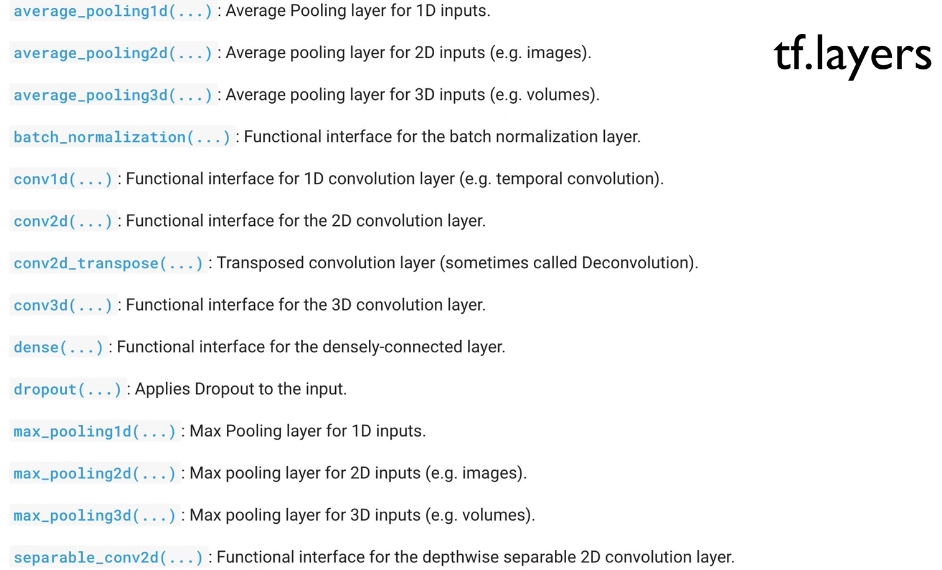

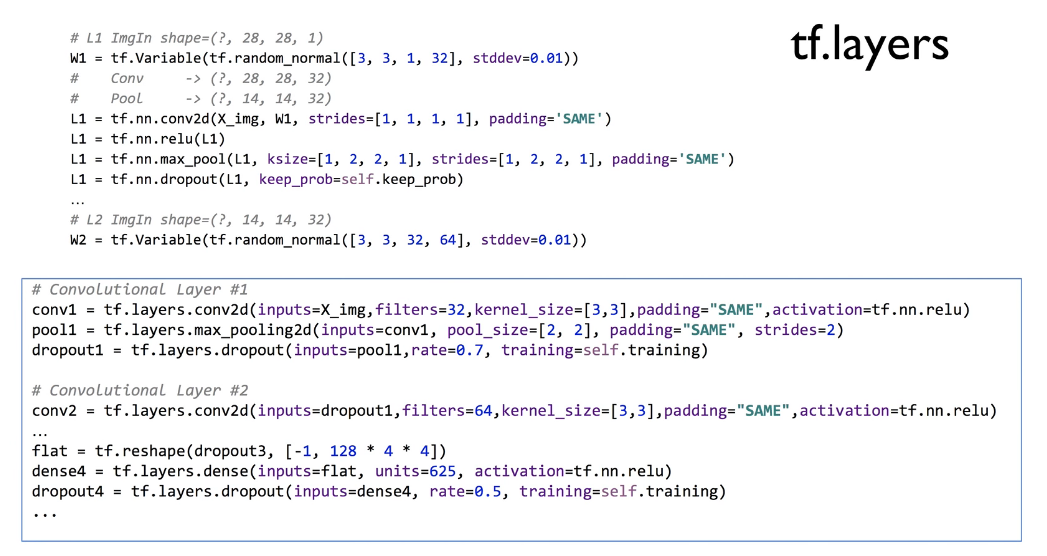

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

In [ ]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [ ]:
class Model :
    def __init__(self, sess, name) :
        self.sess = sess
        self.name = name
        self._build_net()
        
    def _build_net(self) :
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            
            self.training = tf.placeholder(tf.bool)
            
            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])
            
            # img 28x28x1 (black/white), Input Layer
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])
            
            # Convolutional Layer #1 and Pooling Layer #1
            conv1 = tf.layers.conv2d(inputs = X_img, filters = 32, kernel_size = [3,3],
                                     padding = 'SMAE', activation = tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(inputs = conv1, pool_size = [2,2],
                                            padding = 'SAME', strides = 2)
            dropout1 = tf.layers.dropout(inputs = pool1, rate = 0.3, training = self.training)
            
            # Convolutional Layer #2 and Pooling Layer #2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2,
                                         rate=0.3, training=self.training)
            
            # Convolutional Layer #3 and Pooling Layer #3
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3],
                                     padding="same", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                                            padding="same", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3,
                                         rate=0.3, training=self.training)
            
            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128*4*4])
            dense4 = tf.layers.dense(inputs = flat, units = 625, activation = tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs = dense4, rate = 0.5, training = self.training)
            
        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)
        
        correction_prediction = tf.equal(tf.argmax(self.logits,1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,
                             feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,
                             feed_dict={self.X: x_test,
                                        self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.training: training})

In [ ]:
# initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

print('Learning Started!')

In [ ]:
# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        c, _ = m1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

In [ ]:
# Test model and check accuracy
print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))

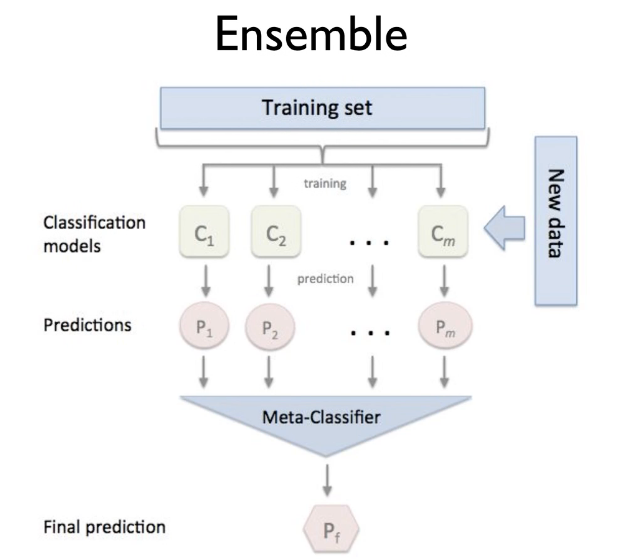

### ensemble_layers

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
# hyper parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 100

In [5]:
class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])

            # img 28x28x1 (black/white), Input Layer
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])

            # Convolutional Layer #1
            conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            # Pooling Layer #1
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1,
                                         rate=0.3, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2,
                                         rate=0.3, training=self.training)

            # Convolutional Layer #3 and Pooling Layer #3
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3,
                                         rate=0.3, training=self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs=flat,
                                     units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4,
                                         rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=10)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,
                             feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,
                             feed_dict={self.X: x_test,
                                        self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.training: training})

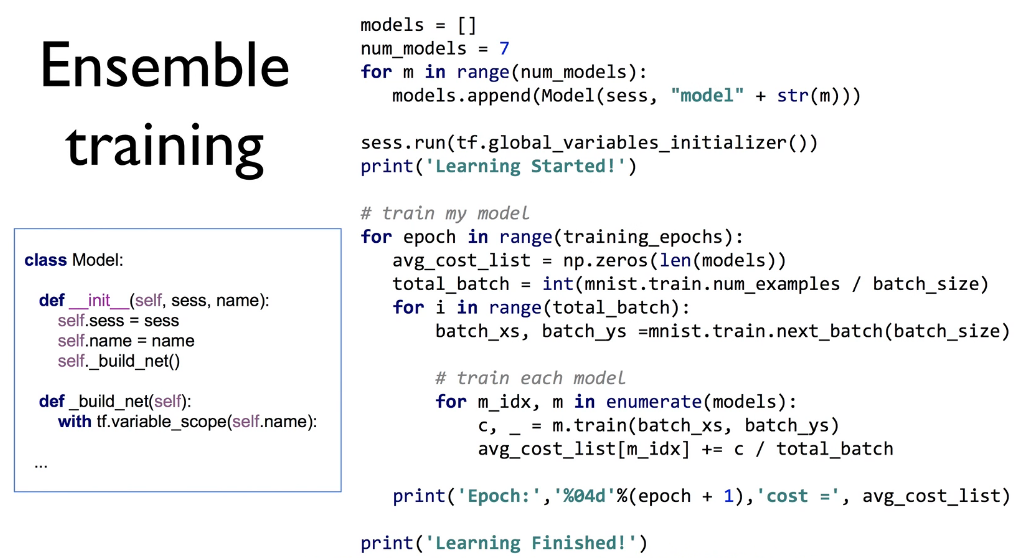

In [6]:
# initialize
sess = tf.Session()

models = []
num_models = 2
for m in range(num_models):
    models.append(Model(sess, "model" + str(m)))

sess.run(tf.global_variables_initializer())

print('Learning Started!')

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Learning Started!


In [ ]:
for epoch in range(training_epochs):
    avg_cost_list = np.zeros(len(models))
    total_batch = int(mnist.train.num_examples / batch_size)
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        # train each model
        for m_idx, m in enumerate(models):
            c, _ = m.train(batch_xs, batch_ys)
            avg_cost_list[m_idx] += c / total_batch
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', avg_cost_list)
print('Learning Finished!')

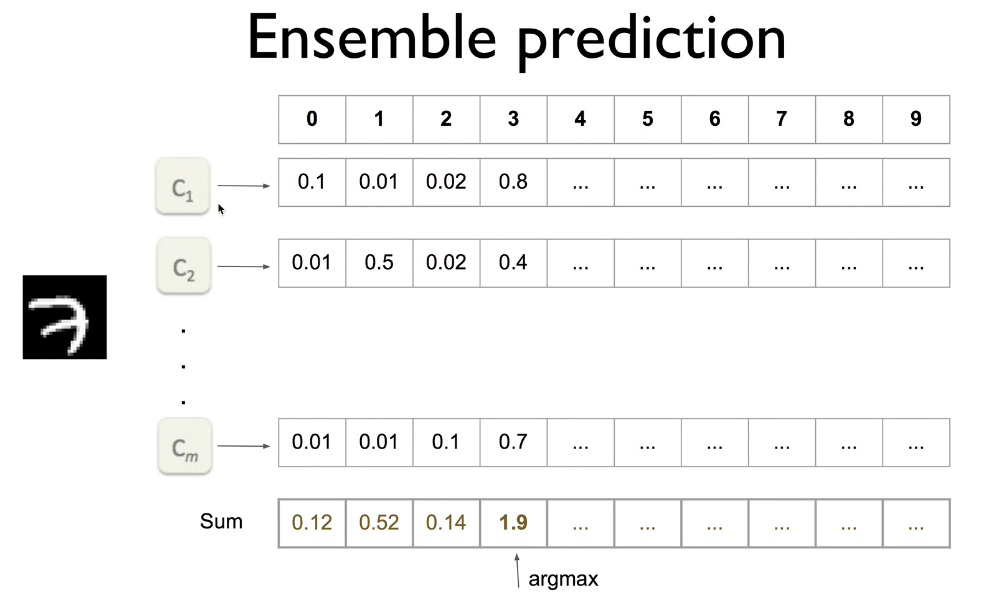

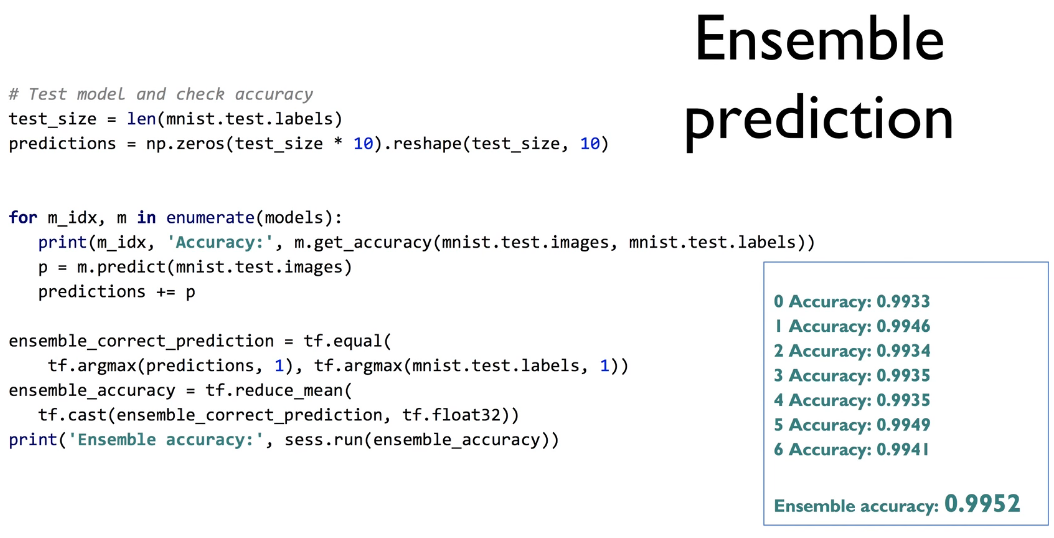

In [ ]:
# Test model and check accuracy

test_size = len(mnist.test.labels)
predictions = np.zeros([test_size, 10])

for m_idx, m in enumerate(models):
    print(m_idx, 'Accuracy :', m.get_accuracy(mnist.test.images, mnist.test.labes))
    p = m.predict(mnist.test.images)
    predictions += p
    
ensemble_correct_prediction = tf.equal(tf.argmax(predictions,1), tf.argmax(mnist.test.labels, 1))
ensemble_accuracy = tf.reduce_mean(tf.cast(ensemble_correct_prediction, tf.float32))
print('Ensemble accuracy:', sess.run(ensemble_accuracy))

In [26]:
for m_idx, m in enumerate(models):
    print(m_idx,m)

0 <__main__.Model object at 0x000001CE140F04E0>
1 <__main__.Model object at 0x000001CE23B510F0>
